In [0]:
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pylab as plt
import copy
from multiprocessing import Pool

class Node:
    def __init__(self, predict, parent_feature_val =None, data=None, values=None):
        if values is None:
            values = {}
        self.data = data
        self.values = values
        self.parent_feature_val = parent_feature_val
        self.predict = predict


def create_data(m,  k=21):
    col_names = []
    weights = []
    sum = 0
    for i in range(k):
        col_names.append("X" + str(i))
    col_names.append("Y")
    data = []
    for i in range(m):
        lst = []
        counts=0
        lst.append(random.randint(0, 1))
        for j in range(1, 15):
            choices = [lst[j-1], 1-lst[j-1]]
            prob = [0.75, 0.25]
            lst.append(np.random.choice(choices, p=prob))
        for j in range(15,21):
            lst.append(random.randint(0,1))
        if lst[0]==0:
            counts = np.bincount(np.array(lst[1:8]))
        else:
            counts = np.bincount(np.array(lst[8:15]))
        lst.append(np.argmax(counts))
        data.append(lst)

    return pd.DataFrame(data, columns=col_names)


class DecisionTreeID3:

    def __init__(self,tree=None):
        self.tree=tree

    def _entropy(self,y):

        res=0
        prob=dict(y.value_counts(normalize=True))
        for key in prob:
            res-= prob[key]*np.log2(prob[key])
        return res


    def _max_info_gain(self,data):
        info_gain={}
        for i in list(data)[:-1]:
            res=0
            entr={}
            x=dict(data[i].value_counts(normalize=True))
            for key in x:
                data_split=self._split(data,key,i)
                entr[key]=self._entropy(data_split["Y"])
                res+=x[key]*entr[key]
            info_gain[i]=self._entropy(data["Y"])-res

        return info_gain

    def _split(self, data, key, feature):
        
        return data[data[feature] == key]



    def fit_tree(self,data,threshhold=None, tree = None):
       
        if tree == None:
            tree = Node(predict =-1)
            self.tree = tree
        if len(data["Y"].unique())==1:
            tree.data=-1
            tree.predict=int(data["Y"].unique())
            return

         
        #if len(data["Y"].unique())==0:
        #    return
        info_gain=self._max_info_gain(data)
        feature=max(info_gain,key= lambda k:info_gain[k])
        if self.chi_square(data,feature)<threshhold:
          return
          
        tree.data=feature
      
        for i in data[feature].unique():
            temp = Node(predict = -1)
            tree.values[i]= temp
        for j in tree.values:
            #if len(data["Y"].unique()!=1 and tree.data!=-1):
            data_split=self._split(data,j,feature)
            self.fit_tree(data_split,threshhold,tree.values[j])


    def _predict_row(self,tree,row):
        current_node=tree
        feature = current_node.data
        while(feature!=-1 and feature is not None):
            x=row[current_node.data]
            current_node=current_node.values[int(row[current_node.data])]
            feature = current_node.data
        return current_node.predict


    def predict (self, data):

        y = []

        for i in range(data.shape[0]):
            predicted_val = (self._predict_row(self.tree, data.iloc[[i]]))
            y.append(predicted_val)
        return y

    def error (self, test_data):
        wrong_prediction_count = 0
        predicted_values = self.predict(test_data)
        for i in range(len(predicted_values)):
            if predicted_values[i] != test_data["Y"][i]:
                wrong_prediction_count+= 1
        #print(predicted_values)
        #print(test_data["Y"])
        return wrong_prediction_count/len(test_data)

    #def fun(self, data):
     #   m = data[0]
      #  test_data = data[1]
       # self.fit_tree(create_data(m),tree=None)
        #iter_error=(self.error(test_data))
        #return iter_error


    def typical_error (self, m):
        test_data = create_data(300)
        error_on_m = []
        for k in range(10):
             self.fit_tree(create_data(m),tree=None)
             iter_error = 0
             iter_error=(self.error(test_data))
             error_on_m.append(iter_error)
        return sum(error_on_m)/10

    def find_irrelevant_features(self,tree,feature_list):
        temp=tree

        if temp:
            children = temp.values
            if temp.data in ["X15","X16","X17","X18","X19","X20"]:
                feature_list.append(temp.data)
            for i in children:
                self.find_irrelevant_features(children[i],feature_list)
        return len(set(feature_list))
    def chi_square(self,data,feature):
        x=dict(data[feature].value_counts(normalize=True))
        y_temp=dict(data["Y"].value_counts(normalize=True))
        t=0
        for i in x:
            for j in y_temp:
                expected_value= x[i]*y_temp[j]*len(data)
                actual_number_of_occurences= len(data[(data[feature]==i) &(data["Y"]==j )])
                t+= math.pow((expected_value-actual_number_of_occurences),2)/expected_value
        return t


# feature_list=[]

# tup_list=[]
# dict_train={}
# dict_test={}
# dict_irr={}
# data=create_data(10000)
# train_data,test_data=data[:8001].reset_index(drop=True),data[8001:].reset_index(drop=True)
# model= DecisionTreeID3()

# for i in tqdm(np.arange(0,5,0.5)):
#   feature_list=[]
#   model.fit_tree(train_data,i,model.tree)
# #   dict_train[i]=model.error(train_data)
# #   dict_test[i]=model.error(test_data)
#   dict_irr[i]=model.find_irrelevant_features(model.tree,feature_list)
#   print(dict_irr)
 

 
# plt.plot(list(dict_irr.keys()),list(dict_irr.values()))
# plt.xlabel("To Threshhold")
# plt.ylabel("irrelevant variables")
# plt.show()






  0%|          | 0/10 [00:00<?, ?it/s]

{1: 0.0}






 20%|██        | 2/10 [00:13<00:52,  6.51s/it]

{1: 0.0, 101: 2.8}






 30%|███       | 3/10 [00:33<01:13, 10.56s/it]

{1: 0.0, 101: 2.8, 201: 3.6}






 40%|████      | 4/10 [01:02<01:37, 16.28s/it]

{1: 0.0, 101: 2.8, 201: 3.6, 301: 5.3}






 50%|█████     | 5/10 [01:37<01:49, 21.94s/it]

{1: 0.0, 101: 2.8, 201: 3.6, 301: 5.3, 401: 3.2}






 60%|██████    | 6/10 [02:18<01:50, 27.51s/it]

{1: 0.0, 101: 2.8, 201: 3.6, 301: 5.3, 401: 3.2, 501: 4.4}






 70%|███████   | 7/10 [03:05<01:39, 33.27s/it]

{1: 0.0, 101: 2.8, 201: 3.6, 301: 5.3, 401: 3.2, 501: 4.4, 601: 4.6}






 80%|████████  | 8/10 [03:55<01:16, 38.31s/it]

{1: 0.0, 101: 2.8, 201: 3.6, 301: 5.3, 401: 3.2, 501: 4.4, 601: 4.6, 701: 5.2}






 90%|█████████ | 9/10 [04:53<00:44, 44.38s/it]

{1: 0.0, 101: 2.8, 201: 3.6, 301: 5.3, 401: 3.2, 501: 4.4, 601: 4.6, 701: 5.2, 801: 5.3}






100%|██████████| 10/10 [05:54<00:00, 49.23s/it]





{1: 0.0, 101: 2.8, 201: 3.6, 301: 5.3, 401: 3.2, 501: 4.4, 601: 4.6, 701: 5.2, 801: 5.3, 901: 4.7}


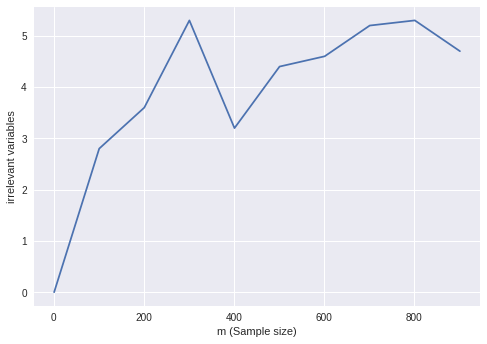

In [22]:
dict_m={}
for i in tqdm(range(1,1001,100)):
  feature_list=[]
  num=0
  for j in range(10):
      model.fit_tree(create_data(i),3.5,model.tree)
#   dict_train[i]=model.error(train_data)
#   dict_test[i]=model.error(test_data)
      num+=model.find_irrelevant_features(model.tree,feature_list)
  dict_m[i]=num/10
  print(dict_m)
 

 
plt.plot(list(dict_m.keys()),list(dict_m.values()))
plt.xlabel("m (Sample size)")
plt.ylabel("irrelevant variables")
plt.show()





  0%|          | 0/9 [00:00<?, ?it/s]



 11%|█         | 1/9 [03:43<29:46, 223.29s/it]

{1: 0.0, 101: 2.8, 201: 3.6, 301: 5.3, 401: 3.2, 501: 4.4, 601: 4.6, 701: 5.2, 801: 5.3, 901: 4.7, 2000: 5.1, 3000: 5.5, 4000: 5.6, 5000: 5.3, 6000: 5.5, 7000: 5.3, 8000: 4.5, 9000: 5.2, 10000: 4.1}






 22%|██▏       | 2/9 [08:43<28:45, 246.48s/it]

{1: 0.0, 101: 2.8, 201: 3.6, 301: 5.3, 401: 3.2, 501: 4.4, 601: 4.6, 701: 5.2, 801: 5.3, 901: 4.7, 2000: 5.1, 3000: 5.5, 4000: 5.6, 5000: 5.3, 6000: 5.5, 7000: 5.3, 8000: 4.5, 9000: 5.2, 10000: 4.1, 20000: 5.5}






 33%|███▎      | 3/9 [14:41<27:58, 279.69s/it]

{1: 0.0, 101: 2.8, 201: 3.6, 301: 5.3, 401: 3.2, 501: 4.4, 601: 4.6, 701: 5.2, 801: 5.3, 901: 4.7, 2000: 5.1, 3000: 5.5, 4000: 5.6, 5000: 5.3, 6000: 5.5, 7000: 5.3, 8000: 4.5, 9000: 5.2, 10000: 4.1, 20000: 5.5, 30000: 4.3}






 44%|████▍     | 4/9 [21:19<26:17, 315.41s/it]

{1: 0.0, 101: 2.8, 201: 3.6, 301: 5.3, 401: 3.2, 501: 4.4, 601: 4.6, 701: 5.2, 801: 5.3, 901: 4.7, 2000: 5.1, 3000: 5.5, 4000: 5.6, 5000: 5.3, 6000: 5.5, 7000: 5.3, 8000: 4.5, 9000: 5.2, 10000: 4.1, 20000: 5.5, 30000: 4.3, 40000: 4.8}






 56%|█████▌    | 5/9 [28:43<23:35, 353.82s/it]

{1: 0.0, 101: 2.8, 201: 3.6, 301: 5.3, 401: 3.2, 501: 4.4, 601: 4.6, 701: 5.2, 801: 5.3, 901: 4.7, 2000: 5.1, 3000: 5.5, 4000: 5.6, 5000: 5.3, 6000: 5.5, 7000: 5.3, 8000: 4.5, 9000: 5.2, 10000: 4.1, 20000: 5.5, 30000: 4.3, 40000: 4.8, 50000: 5.3}






 67%|██████▋   | 6/9 [36:52<19:43, 394.52s/it]

{1: 0.0, 101: 2.8, 201: 3.6, 301: 5.3, 401: 3.2, 501: 4.4, 601: 4.6, 701: 5.2, 801: 5.3, 901: 4.7, 2000: 5.1, 3000: 5.5, 4000: 5.6, 5000: 5.3, 6000: 5.5, 7000: 5.3, 8000: 4.5, 9000: 5.2, 10000: 4.1, 20000: 5.5, 30000: 4.3, 40000: 4.8, 50000: 5.3, 60000: 5.0}






 78%|███████▊  | 7/9 [45:44<14:31, 435.64s/it]

{1: 0.0, 101: 2.8, 201: 3.6, 301: 5.3, 401: 3.2, 501: 4.4, 601: 4.6, 701: 5.2, 801: 5.3, 901: 4.7, 2000: 5.1, 3000: 5.5, 4000: 5.6, 5000: 5.3, 6000: 5.5, 7000: 5.3, 8000: 4.5, 9000: 5.2, 10000: 4.1, 20000: 5.5, 30000: 4.3, 40000: 4.8, 50000: 5.3, 60000: 5.0, 70000: 5.4}






 89%|████████▉ | 8/9 [55:20<07:57, 477.83s/it]

{1: 0.0, 101: 2.8, 201: 3.6, 301: 5.3, 401: 3.2, 501: 4.4, 601: 4.6, 701: 5.2, 801: 5.3, 901: 4.7, 2000: 5.1, 3000: 5.5, 4000: 5.6, 5000: 5.3, 6000: 5.5, 7000: 5.3, 8000: 4.5, 9000: 5.2, 10000: 4.1, 20000: 5.5, 30000: 4.3, 40000: 4.8, 50000: 5.3, 60000: 5.0, 70000: 5.4, 80000: 4.8}






100%|██████████| 9/9 [1:05:32<00:00, 518.18s/it]





{1: 0.0, 101: 2.8, 201: 3.6, 301: 5.3, 401: 3.2, 501: 4.4, 601: 4.6, 701: 5.2, 801: 5.3, 901: 4.7, 2000: 5.1, 3000: 5.5, 4000: 5.6, 5000: 5.3, 6000: 5.5, 7000: 5.3, 8000: 4.5, 9000: 5.2, 10000: 4.1, 20000: 5.5, 30000: 4.3, 40000: 4.8, 50000: 5.3, 60000: 5.0, 70000: 5.4, 80000: 4.8, 90000: 3.5}


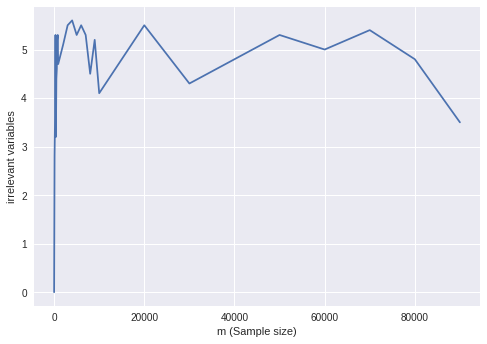

In [24]:
for i in tqdm(range(10000,100000,10000)):
  feature_list=[]
  num=0
  for j in range(10):
      model.fit_tree(create_data(i),3.5,model.tree)
#   dict_train[i]=model.error(train_data)
#   dict_test[i]=model.error(test_data)
      num+=model.find_irrelevant_features(model.tree,feature_list)
  dict_m[i]=num/10
  print(dict_m)
 

 
plt.plot(list(dict_m.keys()),list(dict_m.values()))
plt.xlabel("m (Sample size)")
plt.ylabel("irrelevant variables")
plt.show()

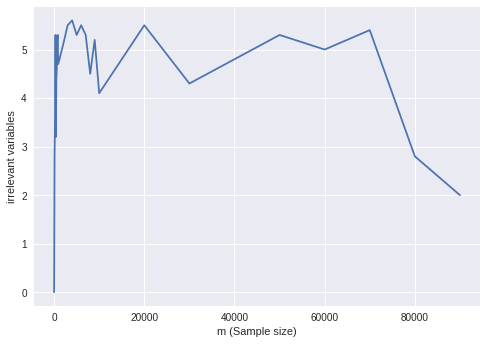

In [6]:
dict={1: 0.0, 101: 2.8, 201: 3.6, 301: 5.3, 401: 3.2, 501: 4.4, 601: 4.6, 701: 5.2, 801: 5.3, 901: 4.7, 2000: 5.1, 3000: 5.5, 4000: 5.6, 5000: 5.3, 6000: 5.5, 7000: 5.3, 8000: 4.5, 9000: 5.2, 10000: 4.1, 20000: 5.5, 30000: 4.3, 40000: 4.8, 50000: 5.3, 60000: 5.0, 70000: 5.4, 80000: 2.8, 90000: 2}
# for i in tqdm(range(100000,110000,2000)):
#   feature_list=[]
#   num=0
#   for j in range(5):
#       model=DecisionTreeID3()
#       model.fit_tree(create_data(i),3.5,model.tree)
# #   dict_train[i]=model.error(train_data)
# #   dict_test[i]=model.error(test_data)
#       num+=model.find_irrelevant_features(model.tree,feature_list)
#   dict[i]=num/5
#   print(dict)
 

 
plt.plot(list(dict.keys()),list(dict.values()))
plt.xlabel("m (Sample size)")
plt.ylabel("irrelevant variables")
plt.show()

In [0]:
dict_train={0.0: 0.0, 0.5: 0.0, 1.0: 0.0, 1.5: 0.0004999375078115235, 2.0: 0.001999750031246094, 2.5: 0.01724784401949756, 3.0: 0.031371078615173104, 3.5: 0.049993750781152355, 4.0: 0.0594925634295713, 4.5: 0.11261092363454568}
dict_test={0.0: 0.01150575287643822, 0.5: 0.01150575287643822, 1.0: 0.01150575287643822, 1.5: 0.014007003501750876, 2.0: 0.015507753876938469, 2.5: 0.02801400700350175, 3.0: 0.04302151075537769, 3.5: 0.05902951475737869, 4.0: 0.06903451725862932, 4.5: 0.128064032016008}

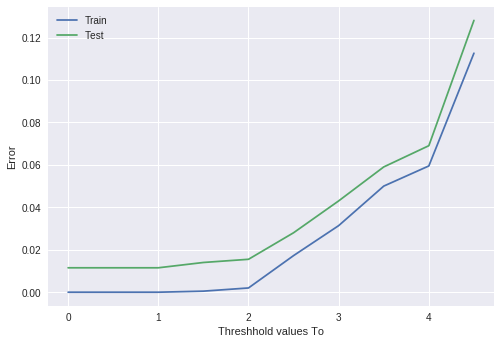

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(list(dict_train.keys()),list(dict_train.values()),label="Train")

plt.plot(list(dict_test.keys()),list(dict_test.values()),label="Test")
plt.xlabel("Threshhold values To")
plt.ylabel("Error")
plt.legend()


plt.show()

In [0]:
dict_test

{0.0: 0.013506753376688344,
 0.5: 0.013506753376688344,
 1.0: 0.013506753376688344}